# Sentiment Analysis

Intro goes here

# Table of Contents
* [Sentiment Analysis on FOMC Statements](#Sentiment-Analysis)
	* [Part 1: Preparations and Topic Analysis](#Q1-Predicting-Elections-from-Samples)
		* [1.1 Natural Language Processing](#Natural-Language-Processing)
		* [1.2 Topic Extraction](#Topic-Extraction)
    * [Part 2: Naive Bayes Classification](#Part-2:-Naive-Bayes-Approach)
        * [2.1 First Approach: Training a Naive Bayes Classifier](#2.1:-First-Approach:-Training-a-Naive-Bayes-Classifier)
        * [2.2 Finding the most important features](#2.2:-Most-important-features)
    * [Part 3: Second Approach: Using the Loughran-McDonald Financial Dictionary](#Part-3:-Second-Approach:-Using-the-Loughran-McDonald-Financial-Dictionary)
        * [3.1: Adjusting the dictionary for our needs](#3.1:-Adjusting-the-dictionary-for-our-needs)
        * [3.2: Most positive and most negative sentences](#3.2:-Most-positive-and-most-negative-sentences)
        * [3.3: Classification using new probabilities](#3.3:-Classification-using-new-probabilities)
    * [Part 4: "Directional Policy": Lengths of Statements and Federal Reserve Policy](#Part-4:-"Directional-Policy":-Lengths-of-Statements-and-Federal-Reserve-Policy)
        * [4.1: Regressing outcome against length](#4.1:-Regressing-outcome-against-length)
        * [4.2: Commentary](#4.2: Commentary)
    * [Part 5: Ensemble method](#Part-5:-Ensemble-method)
    * [Part 6: Conclusion](#Part-6:-Conclusion)
        * [6.1: Results](#6.1:-Results)
        * [6.2: Evaluation](#6.2:-Evaluation)
			
 

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
from pyquery import PyQuery as pq

# Part 1: Preparations and Topic Extraction

### Natural Language Processing

We begin by parsing the text and pre-processing it to prepare it for Latent Dirichlet Analysis. This step is meant to remove stopwords and identify nouns and adjectives.

In [2]:
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')

In [3]:
from sklearn.feature_extraction import text 
stopwords=text.ENGLISH_STOP_WORDS

The FOMC statements are full of phrases like "growth is expected to continue--given the current data--at a moderate pace". The two hyphens should be treated as a space.

In [4]:
import re
regex1=re.compile(r"\-{2,}")

We now define a function to find the nouns and adjectives of the text. The function returns a tuple where the first element is a list of lists, where each list includes the nouns from a sentence. The second element is a list of lists, where each list includes the adjectives from a sentence.

In [5]:
def modified_get_parts(thetext):
    thetext=re.sub(regex1, ', ', thetext)
    nouns=[]
    descriptives=[]
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        
        # Skip the first three sentences that include the HTML
        nouns.append([])
        descriptives.append([])
#         if i in range(1,4):
#             continue
            
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
            
                    descriptives[i].append(token[4])
                elif token[1] in ['NN', 'NNS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns[i].append(token[4])
    out=zip(nouns, descriptives)
    nouns2=[]
    descriptives2=[]
    for n,d in out:
        if len(n)!=0 and len(d)!=0:
            nouns2.append(n)
            descriptives2.append(d)
    return nouns2[1:], descriptives2[1:]

We load in the fomc_mins_all dictionary that we created in the Scraping.ipynb iPython Notebook.

In [6]:
with open("fomc_mins_all.json", "rb") as infile:
    fomc_mins = json.load(infile)

We can now check how our modified_get_parts function would deal with a sample FOMC statement, printing out the first two noun lists.

In [7]:
modified_get_parts(pq(fomc_mins['20140730']).text())[0][:2]

[[u'buildmenu',
  u'policy',
  u'minute',
  u'meeting',
  u'office',
  u'governor',
  u'present',
  u'member',
  u'president',
  u'economist',
  u'dev'],
 [u'governor',
  u'governor',
  u'adviser',
  u'governor',
  u'governor',
  u'governor',
  u'merten',
  u'interval',
  u'meeting',
  u'subcommittee',
  u'communication',
  u'issue']]

We run modified_get_parts on each fomc statement and create a new dictionary fomc_parts. We strip each statement of the html at its start before passing it to modified_get_parts.

In [8]:
%%time
fomc_parts = {}
for key in fomc_mins.keys():
    fomc_parts[key] = modified_get_parts(pq(fomc_mins[key]).text())

Wall time: 1min 46s


In [9]:
fomc_parts_file = open("fomc_parts.json", "wb")
json.dump(fomc_parts, fomc_parts_file)
fomc_parts_file.close()

We can now create two lists, a list of nouns for each sentence, and a flattened list of all the nouns which we will create to produce a dictionary (needed as an argument for the LDA function).

In [10]:
nvocab = []
for key in fomc_mins.keys():
    nouns = fomc_parts[key][0]
    for nounlist in nouns:
        nvocab.append(nounlist)

flattenednvocab = []
for key in fomc_mins.keys():
    nouns = fomc_parts[key][0]
    for nounlist in nouns:
        for n in nounlist:
            flattenednvocab.append(n)

In [11]:
from collections import Counter
frequency = Counter(flattenednvocab)

In [12]:
id2word = {}; vocab = {}
for i,word in enumerate(frequency.keys()):
    vocab[word] = i 
    id2word[i] = word

In [13]:
len(vocab.keys())

2767

In [14]:
from collections import defaultdict
def sentencelist(sentence):
    d = defaultdict(int); group = []
    for word in sentence:
        word_id = vocab[word] 
        d[word_id] += 1 
    group = [(a, d[a]) for a in d.keys()]
    return group
corpus = [sentencelist(sentence) for sentence in nvocab]

## Topic Extraction

In [15]:
import gensim

In [16]:
lda2 = gensim.models.ldamodel.LdaModel(corpus, num_topics=2, id2word = id2word, update_every=1, chunksize=300)

In [17]:
lda2.print_topics()

[(0,
  u'0.050*inflation + 0.046*price + 0.030*rate + 0.024*quarter + 0.023*year + 0.022*increase + 0.020*month + 0.020*labor + 0.019*level + 0.019*consumer'),
 (1,
  u'0.040*market + 0.035*policy + 0.023*member + 0.023*participant + 0.021*condition + 0.020*rate + 0.020*growth + 0.019*meeting + 0.017*period + 0.015*business')]

*Some commment on the topic extraction*

In [18]:
for bow in corpus[0:900:15]:
    print bow
    print lda2.get_document_topics(bow)
    print " ".join([id2word[e[0]] for e in bow])
    print "=========================================="

[(2559, 1)]
[(0, 0.25001638273816545), (1, 0.7499836172618346)]
member
[(1600, 1), (2361, 1), (2470, 1), (641, 1)]
[(0, 0.10551812154773495), (1, 0.89448187845226512)]
issue bid ability dealer
[(1494, 1), (134, 1), (2582, 1)]
[(0, 0.16169646839127449), (1, 0.83830353160872551)]
paragraph currency transaction
[(1040, 1), (2137, 1), (834, 1), (163, 1), (140, 1)]
[(0, 0.70398208641002435), (1, 0.2960179135899757)]
sale exchange spot purchase end
[(523, 1), (13, 1), (1590, 1), (2591, 1)]
[(0, 0.70416441247671635), (1, 0.29583558752328376)]
character swap operation drawing
[(68, 1), (388, 1), (105, 1), (1773, 1), (1714, 1), (19, 1), (1398, 1), (676, 2), (2559, 1)]
[(0, 0.047171915534486124), (1, 0.95282808446551392)]
balance approach assessment announcement wording risk condition time member
[(2624, 1), (1227, 1), (905, 1), (779, 1), (844, 1), (892, 1), (2258, 1), (915, 1), (2649, 1), (924, 1)]
[(0, 0.73836853028828997), (1, 0.26163146971171003)]
loss improvement quarter market recovery hal

*We find there to be three main topics that can be extracted from the corpus. The first topic is related to actions of the Federal Reserve and its assessment of the economy. The inclusion of words like "development", "growth", "policy", "meeting", etc. all speak to the objectives of the Fed and its focus on economic growth.*

*Topic two relates to deals, and economic transactions. Relevant words include "security", "repurchase", "transaction", "purchase", "sale", and "exchange". These are all words relating to transactions and economic activity.*

*Finally, topic three relates to broader macroeconomic trends and positive public perception of the economy. Here, relevant words include "income", "confidence", "outlook", "consumer spending", "strength", and "appreciation". This topic seems to imply a perception of growth or economic development*

## Part 2: Naive Bayes Approach

*Comment on carrying out naive bayes and the fact that we will do it 2 ways.*

### 2.1: First Approach: Training a Naive Bayes Classifier

We create the vocabulary of adjectives that we will use.

In [19]:
flattened_adj_vocab = []
for key in fomc_mins.keys():
    nouns = fomc_parts[key][1]
    for nounlist in nouns:
        for n in nounlist:
            flattened_adj_vocab.append(n)

frequency2 = Counter(flattened_adj_vocab)
id2adj = {}; adjvocab = {}
for i,word in enumerate(frequency2.keys()):
    adjvocab[word] = i 
    id2adj[i] = word

We combine the adjectives in each statement into a single list and thereby have a list of adjectives for each review.

In [20]:
X = []
for key in fomc_mins.keys():
    nouns = fomc_parts[key][1]
    for nounlist in nouns:
        X.append(nounlist)

The most common words...

In [21]:
dict_words = Counter(flattened_adj_vocab)
list_words = []
for key in dict_words:
    list_words.append((dict_words[key], key))
sorted(list_words, reverse=True)

[(5397, u'economic'),
 (3076, u'recent'),
 (2884, u'financial'),
 (2771, u'foreign'),
 (2240, u'monetary'),
 (1906, u'federal'),
 (1768, u'intermeeting'),
 (1752, u'likely'),
 (1550, u'real'),
 (1321, u'low'),
 (1298, u'domestic'),
 (1222, u'consistent'),
 (1170, u'moderate'),
 (1100, u'higher'),
 (1068, u'little'),
 (1047, u'current'),
 (1014, u'fourth'),
 (976, u'second'),
 (940, u'new'),
 (888, u'strong'),
 (881, u'high'),
 (864, u'appropriate'),
 (856, u'overall'),
 (813, u'large'),
 (778, u'available'),
 (733, u'longer-term'),
 (724, u'open'),
 (688, u'substantial'),
 (669, u'fiscal'),
 (658, u'nominal'),
 (630, u'average'),
 (629, u'unchanged'),
 (626, u'previous'),
 (616, u'major'),
 (606, u'industrial'),
 (601, u'sustainable'),
 (584, u'robust'),
 (579, u'total'),
 (557, u'potential'),
 (554, u'retail'),
 (541, u'significant'),
 (535, u'additional'),
 (515, u'unanimous'),
 (513, u'longer-run'),
 (508, u'sizable'),
 (499, u'commercial'),
 (498, u'past'),
 (496, u'lower'),
 (495,

### Our Response Array

In [22]:
with open("actions_05-15.json", "rb") as infile:
    decisions = json.load(infile)
len(decisions.keys())

52

In [23]:
decisions_work = decisions.copy()
new_decisions = {}
for key in fomc_mins:
    if key in decisions_work.keys():
        new_decisions[key] = decisions_work[key][-1]
        del decisions_work[key]
        
len(new_decisions)

51

We now have a group of statements and decisions, where the statements are releases made at certain dates and decisions are interest rate decisions made at certain dates. We now group the statements between each decision into one string. For example, if a decision is made on 09/28/2014 and the next one is made on 10/18/2014, then the statements in between would be grouped together. This allows us to match the dimensions of our input and our output.

In [24]:
for key in fomc_mins.keys():
    if key < min(decisions.keys()):
        del fomc_mins[key]

In [25]:
len(fomc_mins)
for key in fomc_mins.keys():
    if key not in decisions.keys():
        decisions[key] = [0,0,0,0,0]
len(fomc_mins.keys())

108

In [26]:
X = []; y = []
for key in fomc_mins.keys():
    l = ""
    adjs = fomc_parts[key][1]
    for adjlist in adjs:
        for a in adjlist:
#             if dict_words[a] > 1000:
            l = l + " " + a
    X.append(l)
    y.append(decisions[key][2])
newy=[]
for a in y:
    if a == 0 or a == -1:
        newy.append(0)
    else:
        newy.append(1)
X = np.array(X)
y = np.array(newy)
X[0]

u' alternate special alternate elected alternate alternate alternate alternate alternate alternate effective alternate alternate effective unanimous official official unanimous unanimous subject satisfactory unanimous small electronic confidential unanimous open necessary recent domestic direct open foreign international regular individual aggregate forward domestic direct competitive reasonable individual pursuant direct competitive reasonable individual effective open overnight competitive lending consistent reasonable total specific single effective open short-term foreign international fiscal pursuant comparable available appropriate corresponding foreign international fiscal appropriate intermeeting exceptional intended federal recent long-run sustainable economic economic financial monetary intermeeting consistent feasible domestic open pursuant fiscal official foreign international eligible short-term so-called repo unanimous foreign necessary foreign express pursuant procedural

In [27]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(len(X)), train_size=0.7)
mask=np.ones(len(X), dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [28]:
def make_xy(X_col, y_col, vectorizer):
    X = vectorizer.fit_transform(X_col)
    y = y_col
    return X, y

In [29]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to 
a Naive Bayes classifier. 
The Log Likelihood is defined by

L = Sum_positive(logP(positive)) + Sum_negative(logP(negative))

Where Sum_positive indicates a sum over all positive reviews, 
and Sum_negative indicates a sum over negative reviews
    
Parameters
----------
clf : Naive Bayes classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten,0].sum() + prob[fresh,1].sum()

In [30]:
from sklearn.cross_validation import KFold

def cv_score(clf, x, y, score_func, nfold=5):
    """
    Uses 5-fold cross validation to estimate a score of a classifier
    
    Inputs
    ------
    clf : Classifier object
    x : Input feature vector
    y : Input class labels
    score_func : Function like log_likelihood, that takes (clf, x, y) as input,
                 and returns a score
                 
    Returns
    -------
    The average score obtained by splitting (x, y) into 5 folds of training and 
    test sets, fitting on the training set, and evaluating score_func on the test set
    
    Examples
    cv_score(clf, x, y, log_likelihood)
    """
    result = 0
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf, x[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [32]:
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
maxi = -np.inf; best_alpha = 0; best_min_df = 0
for m in min_dfs:
    for a in alphas:
        vectorizer = CountVectorizer(vocabulary=adjvocab, min_df = m) 
        x_new, y_new = make_xy(X,y,vectorizer)
        Xtrainthis=x_new[mask]
        ytrainthis=y_new[mask]
        clf = MultinomialNB(alpha=a)
        score = cv_score(clf, Xtrainthis, np.ravel(ytrainthis), log_likelihood)
        if (score > maxi):
            maxi = score
            best_alpha = a
            best_min_df = m

In [33]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 0.100000
min_df: 0.000010


In [34]:
vectorizer = CountVectorizer(vocabulary=adjvocab, min_df=best_min_df)
Xnew, ynew = make_xy(X, y, vectorizer)
xtrain=Xnew[mask]
ytrain=ynew[mask]
xtest=Xnew[~mask]
ytest=ynew[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.4f" % (training_accuracy)
print "Accuracy on test data:     %0.4f" % (test_accuracy)



Accuracy on training data: 0.9467
Accuracy on test data:     0.8485


*Comment on this*

Compare to baseline:

In [35]:
sum([1 for e in y if e == 0])

91

Baseline percentage is 91/108 if all 0s

#### 2.2: Most discriminative features

What are the most discriminative features according to our classifier? The visualization belows shows the top 10 features in terms of the differences between their positive and negative log probabilities for classification.

In [36]:
features_list = vectorizer.get_feature_names()
feature_probs = clf.feature_log_prob_
lognegatives = {}; logpositives = {}; i = 0
positives = []
negatives = []
difference = []

for a in features_list:
    lognegatives[a] = feature_probs[0][i]
    logpositives[a] = feature_probs[1][i]
    positives.append((feature_probs[0][i],a))
    negatives.append((feature_probs[1][i],a))
    difference.append((abs(feature_probs[0][i] - feature_probs[1][i]),a))
    i += 1

sorted_p = sorted(difference, reverse=True)
print sorted_p[:20]


[(6.0546998153949163, u'backed'), (5.9881536555230879, u'upgrade'), (5.8742378314352015, u'mortgage'), (5.7699000895030697, u'flush'), (5.490315227283908, u'attendant'), (5.1008504605221852, u'technological'), (5.1008504605221852, u'refined'), (5.1008504605221852, u'obsolete'), (5.1008504605221852, u'incipient'), (5.1008504605221852, u'attended'), (4.9833323270633123, u'principal'), (4.9385219630343071, u'broader'), (4.8623671962217081, u'sovereign'), (4.8116463861715291, u'gross'), (4.7360164046720463, u'tight'), (4.6042471270409226, u'extended'), (4.5913603507645657, u'primary'), (4.5380854369510155, u'advanced'), (4.4542232955971333, u'wrenching'), (4.4542232955971333, u'wary')]


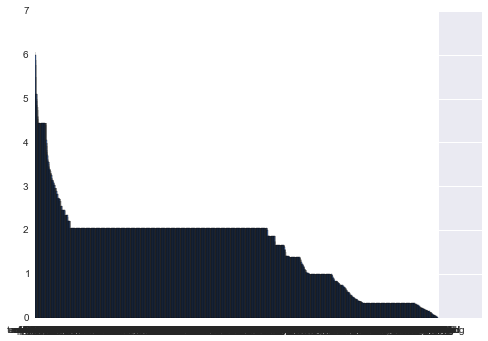

In [37]:
y = [a[0] for a in sorted_p]
x = [a[1] for a in sorted_p]
width = 0.3
plt.bar(np.arange(len(x)),y)
plt.xticks(np.arange(len(x)) + width / 2, x);

Comment on the visualization. Is it what we thouht it would be?

## Part 3: Second Approach: Using the Loughran-McDonald Financial Dictionary

### 3.1: Adjusting the dictionary for our needs

Our first approach assigned probabilities to words based on the training set of FOMC statements we have. However, the success of this is limited by the number of FOMC statements (182) that we have access to. We can improve this analysis by using more accurate probabilities given by a dictionary that focuses on finance. The **Loughran-McDonald 2014 Master Dictionary** is a great tool for our purposes as it includes words that often appear in 10-K documents and other financial statements. The dictionary includes 9 sentiment categories, including "negative", "positive", "uncertainty", "litigious", "modal", and "constraining", among others. The categories given by this dictionary are more useful to us because of the sheer size of the data set used.

We read in the data. Below is an example of the data encapsulated in $lmdf$.

In [38]:
lmdf = pd.read_csv("shortMcDonaldDictionary.csv")
lmdf.head()

,Word,Sequence Number,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Constraining,Superfluous,Interesting,Modal,Irr_Verb,Harvard_IV,Syllables,Source
0,ENCUMBER,24454,87222,6.130000e-06,2.570000e-06,0.000017,44863,2009,0,0,2009,2009,0,0,0,0,0,3,12of12inf
1,ENCUMBERED,24455,86996,6.110000e-06,3.480000e-06,0.000028,44409,2009,0,0,2009,2009,0,0,0,0,0,3,12of12inf
2,ENCUMBERING,24456,51445,3.610000e-06,3.660000e-06,0.000050,19907,2009,0,0,2009,2009,0,0,0,0,0,4,12of12inf
3,ENCUMBERS,24457,4835,3.400000e-07,1.380000e-07,0.000004,3258,2009,0,0,2009,2009,0,0,0,0,0,3,12of12inf
4,ENCUMBRANCE,24458,223181,1.570000e-05,6.260000e-06,0.000036,72129,2009,0,0,2009,2009,0,0,0,0,0,3,12of12inf


In [39]:
lmdf = lmdf[["Word","Negative","Positive","Uncertainty","Litigious","Constraining"]]

In [40]:
lmdf.head()

,Word,Negative,Positive,Uncertainty,Litigious,Constraining
0,ENCUMBER,2009,0,0,2009,2009
1,ENCUMBERED,2009,0,0,2009,2009
2,ENCUMBERING,2009,0,0,2009,2009
3,ENCUMBERS,2009,0,0,2009,2009
4,ENCUMBRANCE,2009,0,0,2009,2009


The dictionary includes 9 sentiment categories (e.g. "negative", "positive", "uncertainty", "litigious", "modal", and "constraining"). We reduce the dimensionality of this data down to just three categories: "negative", "positive", and "uncertain". A $word$ that is "uncertain" is assigned the probabilities $$P(word_u\,|\,-)=P(word_u\,|\,+)=\frac{1}{2}$$
We set words in the "positive" and "negative" parts to have 90% probabilities of being in the group they are assigned to (based on the average probability given by Loughran and McDonald).
$$P(word_p\,|\,+) = 0.9, P(word_p\,|\,-) = 0.1$$
$$P(word_n\,|\,-) = 0.1, P(word_n\,|\,-) = 0.9$$

We adjust $lmdf$ to reflect these decisions.

In [41]:
lmdf_adjusted = lmdf.copy(deep=True)
N = 0; P = 0
new_values = [0 for i in range(len(lmdf_adjusted.values))]
for i, r in enumerate(lmdf_adjusted.values):
    if r[1] > 0 or r[4] > 0 or r[5] > 0:
        N = 0.9; P = 0.1
    elif r[2] > 0:
        N = 0.1; P = 0.9
    elif r[3] > 0:
        N = 0.5; P = 0.5
    new_values[i] = [r[0].lower(), P, N]

final_lmdf = pd.DataFrame(new_values, index=lmdf_adjusted.index, columns = ["Word", "Positive Prob", "Negative Prob"])
final_lmdf.head()

,Word,Positive Prob,Negative Prob
0,encumber,0.1,0.9
1,encumbered,0.1,0.9
2,encumbering,0.1,0.9
3,encumbers,0.1,0.9
4,encumbrance,0.1,0.9


We define a function to calculate the probability of a sentence being positive.

In [42]:
dict_probs = {}
for row in final_lmdf.values:
    dict_probs[row[0]] = [row[1], row[2]]

In [43]:
"""
We modify calc_pplus to incorporate our new found knowledge. We now check if a word is in the financial dictionary first.
If it is then we use that probabilty, otherwise we use the probability from our earlier Naive Bayes classifier.

We also multiply the probabilities from the financial dictionary by a factor to emphasize their importance (based on the
fact that we are more confident in their values).
"""

def modified_calc_pplus(adjlist, dict_probs, lp, ln, pp, pn):
    FACTOR = 1
    
    prob_p = 0; prob_n = 0
    for adj in adjlist:
        # Check if the adjective is in the financial dictionary
        # If it is take, probability from there
        if adj.lower() in dict_probs.keys():
            prob_p += FACTOR * dict_probs[adj][0]
            prob_n += FACTOR * dict_probs[adj][1]
        else:
            prob_p += lp[adj]
            prob_n += ln[adj]
    prob_pos = (10**prob_p) * pp
    prob_neg = (10**prob_n) * pn
    prob = float(prob_pos)/(prob_pos + prob_neg)
    return prob

In [44]:
statements = []
for key in fomc_mins.keys():
    adj = fomc_parts[key][1]
    statements.append(adj)

In [45]:
modified_calc_pplus(statements[0][1], dict_probs, logpositives, lognegatives, np.mean(y), 1-np.mean(y))

1.2383759497924784

### 3.2: Most positive and most negative sentences

Potential commentary: We can find the most "positive" and most "negative" sentences and comment on that.

### 3.3: Classification using new probabilities

We define a function that calculates the probability of a statement being positive or negative. The function calculates the probability of each sentence being positive or negative and then sums up the total probabilities. Finally, it normalizes the overall probability.

In [46]:
def statement_prob_pos(statement, adjlist, dict_probs, lp, ln, pp, pn):
    prob_p = 0; prob_n = 0
    for sent in statement:
        prob_p += np.log10(modified_calc_pplus(sent, dict_probs, lp, ln, pp, pn))
        prob_n += np.log10(1-modified_calc_pplus(sent, dict_probs, lp, ln, pp, pn))
    prob_pos = (10**prob_p) * pp
    prob_neg = (10**prob_n) * pn
    prob = float(prob_pos)/(prob_pos + prob_neg)
    return prob

In [47]:
statement_prob_pos(statements[0], adjlist, dict_probs, logpositives, lognegatives, np.mean(y), 1-np.mean(y))

nan

In [48]:
%%time
X_full = []; y_full = []; our_results = []
for key in fomc_mins.keys():
    adjs = fomc_parts[key][1]
    X_full.append(adjs)
    y_full.append(decisions[key][2])
    prob = statement_prob_pos(adjs, adjlist, dict_probs, logpositives, lognegatives, np.mean(y), 1-np.mean(y))
    if prob <= 0.5:
        prob = 0
    else:
        prob = 1
    our_results.append(prob)

Wall time: 1min 25s


In [49]:
correct = 0
for i in range(len(y_full)):
    if y_full[i] == -1:
        y_full[i] = 0
    if y_full[i] == our_results[i]:
        correct += 1
    score = float(correct)/len(y_full)
print score
print our_results

0.157407407407
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [50]:
print y_full, our_results

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [51]:
def modified_calc_pplus(adjlist, dict_probs, lp, ln, pp, pn):
    FACTOR = 1
    
    prob_p = 0; prob_n = 0
    for adj in adjlist:
        # Check if the adjective is in the financial dictionary
        # If it is take, probability from there
        if adj.lower() in dict_probs.keys():
            prob_p += np.log10(FACTOR * dict_probs[adj][0])
            prob_n += np.log10(FACTOR * dict_probs[adj][1])
        else:
            prob_p += lp[adj]
            prob_n += ln[adj]
    prob_pos = (10**prob_p) * pp
    prob_neg = (10**prob_n) * pn
    prob = float(prob_pos)/(prob_pos + prob_neg)
    return prob

In [52]:
%%time
X_full = []; y_full = []; our_results = []
for key in fomc_mins.keys():
    adjs = fomc_parts[key][1]
    X_full.append(adjs)
    y_full.append(decisions[key][2])
    prob = statement_prob_pos(adjs, adjlist, dict_probs, logpositives, lognegatives, np.mean(y), 1-np.mean(y))
    if prob <= 0.9:
        prob = 0
    else:
        print prob
        prob = 1
    our_results.append(prob)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Wall time: 1min 27s


In [53]:
correct = 0
for i in range(len(y_full)):
    if y_full[i] == -1:
        y_full[i] = 0
    if y_full[i] == our_results[i]:
        correct += 1
    score = float(correct)/len(y_full)
print score
print our_results

0.157407407407
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [54]:
print y_full
print our_results

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [55]:
print "Number of 1s in reality", sum(y_full)
print "Number of 1s according to our model", sum(our_results)

Number of 1s in reality 17
Number of 1s according to our model 108


## Part 4: "Directional Policy": Lengths of Statements and Federal Reserve Policy

### 4.1: Regressing outcome against length

The Federal Reserve has claimed at several points in the past decade that it attempts to affect financial markets (especially post-crisis) through the release of increasingly long statements that help outline and bring about the changes it hopes for. We take this as a launch pad for another potential statistical analysis that may turn out to be useful for our work. We examine the relationship between the length of statements and their outcomes.

Indeed, the length of statements varies greatly from statement to statement. For example, let us compare two statements from 2014 and 2002.

In [56]:
print len(pq(fomc_mins['20140730']).text()), len(pq(fomc_mins['20021210']).text())

53905 22899


The statement from 2014 is twice as long as that of 2002 (this is line with the Fed's promise of more locquacious public statements).

This is pattern is even more striking when we visualize it as shown below.

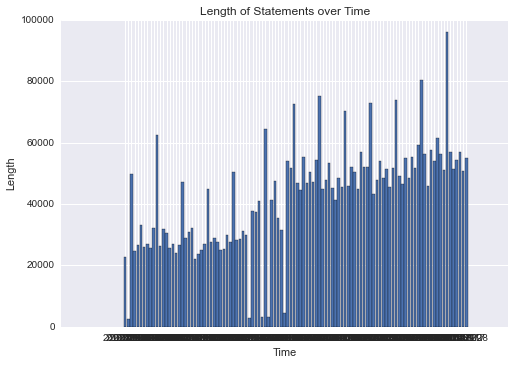

In [57]:
length_time = []
for key in fomc_mins.keys():
    new = (key, len(pq(fomc_mins[key]).text()))
    length_time.append(new)
    
sorted_length = sorted(length_time)

length_time_df = pd.DataFrame(sorted_length, columns = ["Date", "Length"])
length_time_df.head()

# plt.bar(length_time_df["Date"], length_time_df["Length"])
plt.bar(range(len(length_time_df)), length_time_df["Length"], align='center');
plt.xticks(range(len(length_time_df)), length_time_df["Date"]);


plt.xlabel("Time");
plt.ylabel("Length");
plt.title("Length of Statements over Time");

We now prepare data to carry out a regression.

In [58]:
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols

In [59]:
length_ols_model = ols('Y ~ Length', length_data).fit()

NameError: name 'length_data' is not defined

In [ ]:
length_ols_model.summary()

In [ ]:
for key in decisions.keys():
    if decisions[key][2] == -1:
        decisions[key][2] = 0
        
length = []
for key in fomc_mins.keys():
    new = (len(pq(fomc_mins[key]).text()),decisions[key][2])
    length.append(new)
    
length_data = pd.DataFrame(length, columns = ["Length", "Y"])
length_data.head()

In [ ]:
length_ols_model = ols('Y ~ Length', length_data).fit()

In [ ]:
length_ols_model.summary()

Some comment on the $R^2$ value of our data goes here. General comment about whether or not there is a relationship between length of statement and outcome of Fed statement.

In [ ]:
plt.scatter(length_data['Length'], length_data['Y'])

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import logit

length_logistic = logit('Y ~ Length', length_data).fit()
length_logistic.summary()

### 4.2: Commentary

## Part 5: Ensemble method

Ensemble method that brings it all together